In [1]:
#general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
from astropy.time import Time
import copy
import scipy

#nmma modules
nmma = os.getenv("NMMA")
sys.path.append(nmma) #path to nmma
import nmma
import nmma.em.utils as utils
from nmma.em.model import SimpleKilonovaLightCurveModel,GRBLightCurveModel, SVDLightCurveModel, KilonovaGRBLightCurveModel, GenericCombineLightCurveModel
from nmma.em import training, utils, model_parameters

Install wrapt_timeout_decorator if you want timeout simulations.


In [2]:
import afterglowpy as grb

# Generate a light-curve Bulla 2019 model

In [3]:
# model parameters
model_name = "Bu2019lm"
n_coeff = 3
# The array of times we'll use to examine each lightcurve
tini, tmax, dt = 0.1, 5.0, 0.2
tt = np.arange(tini, tmax + dt, dt)  

# The filters we'll be focusing on
filts = ["u","g","r","i","z","y","J","H","K"] 

In [4]:
# paths
dataDir = f"{nmma}/nmma/tests/data/bulla" ## Example absolute path: "/Users/fabioragosta/nmma/nmma/tests/data/bulla"
ModelPath = f"{nmma}/svdmodels" ## Example absolute path: "/Users/fabioragosta/nmma/svdmodels"
filenames = glob.glob(f"{nmma}/*.dat")

In [5]:
# load data
# data = utils.read_photometry_files(filenames, filters=filts) # not compatible with newer NMMA version

In [6]:
# Loads the model data
# training_data, parameters = model_parameters.Bu2019lm_sparse(data)

In [7]:
# #two different interpolation types are possible "sklearn_gp" or "tensorflow"
# interpolation_type = "sklearn_gp"
# training_model=training.SVDTrainingModel(
#     model_name,
#     copy.deepcopy(training_data),
#     parameters,
#     tt,
#     filts,
#     svd_path=ModelPath,
#     n_coeff=n_coeff,
#     interpolation_type=interpolation_type,
#     n_epochs=100
# )

# tmin, tmax, dt = 0.5, 20.0, 0.1
# sample_times = np.arange(tmin, tmax + dt, dt)

# light_curve_model = SVDLightCurveModel(
#         model_name,
#         sample_times,
#         svd_path=ModelPath,
#         interpolation_type=interpolation_type,
#         model_parameters=training_model.model_parameters,
#     )

# 2. Plot AT17gfo light-curve

In [9]:
# import AT2017gfo data
nmma = os.getenv("NMMA")
data = pd.read_csv(f'{nmma}/example_files/lightcurves/AT2017gfo.dat',header=None,delim_whitespace=True)
data.columns = ['time','filter','mag','magerr']

In [10]:
data

,time,filter,mag,magerr
0,2017-08-18T00:00:00.000,ps1::g,17.41,0.02
1,2017-08-18T00:00:00.000,ps1::r,17.56,0.04
2,2017-08-18T00:00:00.000,ps1::i,17.48,0.03
3,2017-08-18T00:00:00.000,ps1::z,17.59,0.03
4,2017-08-18T00:00:00.000,ps1::y,17.46,0.01
...,...,...,...,...
136,2017-09-01T23:29:45.600,2massks,20.17,0.08
137,2017-09-03T23:31:12.000,2massks,20.77,0.13
138,2017-09-04T23:11:02.400,2massks,20.76,0.35
139,2017-09-07T23:15:21.600,2massks,21.46,0.08


In [11]:
# convert ISOT time formats into MJD for plotting
from astropy.time import Time
times = data['time'].values.tolist()
t = Time(times,format='isot')
data['MJD'] = t.mjd

In [18]:
data['filter'].unique()

array(['ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', '2massj',
       '2massh', '2massks', 'sdssu'], dtype=object)

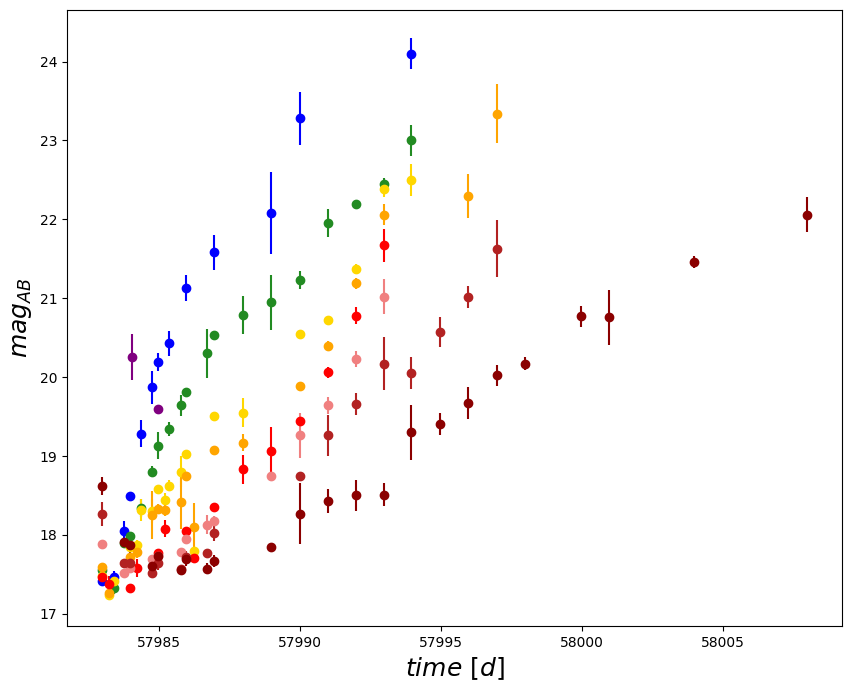

In [26]:
# this method really isn't working too well

colors = {'sdssu':'purple','ps1::g':'blue','ps1::r':'forestgreen','ps1::i':'gold','ps1::z':'orange','ps1::y':'red','2massj':'lightcoral','2massh':'firebrick','2massks':'darkred'}

fig, ax = plt.subplots(1,1,figsize=(10,8))

for flt in data['filter'].unique():
    sel_flt = data[data['filter'] ==flt]
    ax.errorbar(sel_flt['MJD'],sel_flt['mag'],yerr=sel_flt['magerr'],label=flt, color=colors[flt],fmt='o')
ax.set_ylabel(r'$mag_{AB}$', fontsize=18)
ax.set_xlabel(r'$time~[d]$', fontsize=18)
# ax.ticklabel_format(useOffset=False)
# ax.set_ylim([5,-20])
# ax.legend(fontsize=18)
plt.show()

# 3. Fit Bulla 2019 model to AT17gfo

In [ ]:
# not sure how to do model fitting in a jupyter notebook. Have only been able to do this using the command line

# 4. Using Bulla obtained parameters generate AT17gfo-like light-curves at different redshifts and samples